In [0]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# активационная функция
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# производная активационной функции
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

# квадратичная целевая функция
# test_data - кортеж из входных значений и списка значений классов
def cost_function(network, test_data):
    c = 0
    for example, y in test_data:
        c += np.sum((network.feedforward(example) - y) ** 2)
    return c /(2 * len(test_data))


In [0]:
class Network:
    def __init__(self, shape, activation_function, activation_function_derivative, debug= True):
        self.shape = shape
        self.biases = [np.random.randn(y, 1) for y in shape[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(shape[:-1], shape[1:])]
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.debug = debug

    # прогнать до конца примеры из input_matrix
    def feedforward(self, input_matrix):
        for b, w in zip(self.biases, self.weights):
            # weigts - (массив матриц)
            input_matrix = self.activation_function(np.dot(w, input_matrix) + b)
        return input_matrix

    # обновление параметров нейронной сети (веса, смещения), сделав шаг градиентного спуска
    # на основе алгоритма обратного распространения ошибки
    # alpha - learning rate
    def back_prop_step(self, data, alpha):
        # значения dJ/db для каждого слоя
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        # значения dJ/dw (ошибки) для каждого слоя
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # для каждого примера из батча применяем бек пропогейшн
        for x, y in data:
            delta_nabla_b, delta_nabla_w = self.back_prop_single_example(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        eps = alpha / len(data)

        # обновляем параметры сети
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def prepare_data(data, classes_count):
        return [(row[:-classes_count].reshape(-1,1), row[-classes_count:].reshape(-1,1)) for row in data]

    # алгоритм градиентного спуска
    def SGD(self, data_in, epochs, alpha, classes_count):
        prepared_data = Network.prepare_data(data_in, classes_count)
        errors = []
        
        for epoch in range(epochs):
            self.back_prop_step(prepared_data, alpha)
            error = cost_function(self, prepared_data)
            if self.debug:
                print(f'epoch: {epoch} -  error:{error}')
            errors.append(error)
            

        return errors
    
    # возвращает вектор частных производных квадратичной целевой функции по активациям выходного слоя
    def cost_derivative(self, output_activations, y):
        return output_activations - y

    # алгоритм обратного распространения ошибки для одного примера из тренировочной выборки
    # возвращает кортеж (nabla_b, nabla_w) - градиентов по слоям по смещениям и весам соответственно
    def back_prop_single_example(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)
        # массив векторов активаций нейронов
        activations = [x]
        # массив векторов сумматорных функций от активаций предыдущих слоев
        summatories = []
        # b - вектор смещений нейронов данного слоя
        # w - матрица весов, входящих в данный слой
        for b, w in zip(self.biases, self.weights):
            summatories.append(np.dot(w, activations[-1]) + b)
            activation = self.activation_function(summatories[-1])
            activations.append(activation)

        # обратное распространение (backward pass)
        
        # ошибка для выходного слоя
        delta = self.cost_derivative(activations[-1], y) * self.activation_function_derivative(summatories[-1])
        # производная J по биасам выходного слоя
        nabla_b[-1] = delta
        # производная J по весам выходного слоя
        nabla_w[-1] = delta.dot(activations[-2].T)

        # Здесь l = 1 означает последний слой, l = 2 - предпоследний и так далее.  
        for l in range(2, len(self.shape)):
            derivative = self.activation_function_derivative(summatories[-l])
            # ошибка на слое L-l
            delta = derivative * self.weights[-l + 1].T.dot(delta)
            # производная J по смещениям L-l-го слоя
            nabla_b[-l] = delta
            # производная J по весам L-l-го слоя
            nabla_w[-l] = delta.dot(activations[-l - 1].T) 
        return nabla_b, nabla_w

In [0]:
def draw_class(index, normalized_data, class_count):
    class_n = [float(network.feedforward(row[:-class_count].reshape(-1,1))[index]) for row in normalized_data]
    class_real = [float(row[-class_count:].reshape(-1,1)[index]) for row in normalized_data]

    plt.scatter(range(len(class_real)), class_real)
    plt.plot(class_n,'r')
    return class_n

def rmse(network, train_data):
    return np.sqrt(cost_function(network, train_data))

def get_normalized_data(url, classes_count):
    data = pd.read_csv(url, delimiter=';',encoding='windows-1251')
    normalized = (data / data.max())
    normalized.iloc[:, :-classes_count] = normalized.iloc[:, :-classes_count].fillna(0)
    mean = normalized.iloc[:, -classes_count:].mean()
    normalized.iloc[:, -classes_count:] = normalized.iloc[:, -classes_count:].fillna(mean)
    return normalized.to_numpy()       

In [0]:
normalized_train_data = get_normalized_data('https://raw.githubusercontent.com/tigrulya-exe/BackPropogation/master/data.csv', 2)
normalized_test_data = get_normalized_data('https://raw.githubusercontent.com/tigrulya-exe/BackPropogation/master/test_data.csv', 2)

In [0]:
pd.read_csv('https://raw.githubusercontent.com/tigrulya-exe/BackPropogation/master/data.csv', delimiter=';',encoding='windows-1251')


,Глубина манометра,Dшт,Туст_ср,Тзаб_ср,Pлин_ср,Тлин_кон,Туст,Тзаб,Tлин,Дебит_ст_конд.,Дебит_воды,Дебит_кон_нестабильный,Нэф,Рпл_тек_послед,Рпл_тек_квд,Pсб,Ro_c,Удельная_плотность_газа,G_total,КГФ
0,3576.3,7.94,249.60,370.1,101.80,101.80,53.0,103.20,32.50,83.6,0.40,131.3,56.80,45.25,56.5,93.6,801.0,0.6694,2.78,311.91
1,3576.3,9.53,233.50,364.6,101.30,102.40,58.8,103.00,38.60,104.7,1.40,158.5,56.80,45.25,56.5,92.9,801.0,0.6694,3.70,288.60
2,3576.3,11.11,213.40,357.1,101.60,100.60,63.6,102.60,43.40,114.3,1.90,172.3,56.80,45.25,56.5,91.4,801.0,0.6694,4.52,248.79
3,3576.3,12.70,191.60,347.4,98.40,99.00,64.7,102.00,46.10,121.3,3.30,181.5,56.80,45.25,56.5,89.2,801.0,0.6694,5.22,223.56
4,3576.3,14.29,171.90,337.7,99.20,99.50,64.0,104.40,49.90,129.8,4.60,190.6,56.80,45.25,56.5,89.7,801.0,0.6694,5.77,215.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,3284.0,12.70,215.00,307.8,98.60,97.20,65.0,104.78,46.30,93.5,4.70,156.8,44.50,35.28,40.5,94.4,782.0,0.6600,0.85,153.00
89,3284.0,14.29,198.00,293.6,98.50,98.40,66.9,104.63,50.50,106.6,6.40,174.3,44.50,35.28,40.5,94.0,782.0,0.6600,0.96,147.00
90,3288.6,7.94,231.23,309.1,92.60,92.70,51.0,104.40,28.10,50.5,0.45,84.7,48.37,33.21,NaN,89.9,779.6,0.6700,0.46,182.00
91,3288.6,11.11,217.20,293.9,93.10,93.30,60.0,104.60,41.30,72.0,1.50,123.0,48.37,33.21,NaN,90.8,779.6,0.6700,0.65,145.00


In [0]:
network = Network([18, 90, 110, 2], sigmoid, sigmoid_prime, True)
errors = network.SGD(normalized_train_data, epohs=5000, alpha=0.455, classes_count=2)

Streaming output truncated to the last 5000 lines.
epoch: 1 -  error:0.04951479972604003
epoch: 2 -  error:0.048210694152759075
epoch: 3 -  error:0.046485977467874424
epoch: 4 -  error:0.04419525093004769
epoch: 5 -  error:0.04105550623482788
epoch: 6 -  error:0.03713213731488483
epoch: 7 -  error:0.03335077457195021
epoch: 8 -  error:0.031368502178281445
epoch: 9 -  error:0.030438405612541984
epoch: 10 -  error:0.029632959737772854
epoch: 11 -  error:0.028848636817785166
epoch: 12 -  error:0.028126859255591684
epoch: 13 -  error:0.027424675284878654
epoch: 14 -  error:0.026782344141797382
epoch: 15 -  error:0.026156060517847947
epoch: 16 -  error:0.02558668715326499
epoch: 17 -  error:0.02502851537411066
epoch: 18 -  error:0.024524781085741437
epoch: 19 -  error:0.024026684564955582
epoch: 20 -  error:0.023581524167811146
epoch: 21 -  error:0.023135976339895947
epoch: 22 -  error:0.022743162320937402
epoch: 23 -  error:0.02234348318359006
epoch: 24 -  error:0.02199786258764085
epoch: 

In [0]:
network = Network([18, 40, 60, 2], sigmoid, sigmoid_prime, True)
errors = network.SGD(normalized_train_data, epochs=2500, alpha=0.655, classes_count=2)

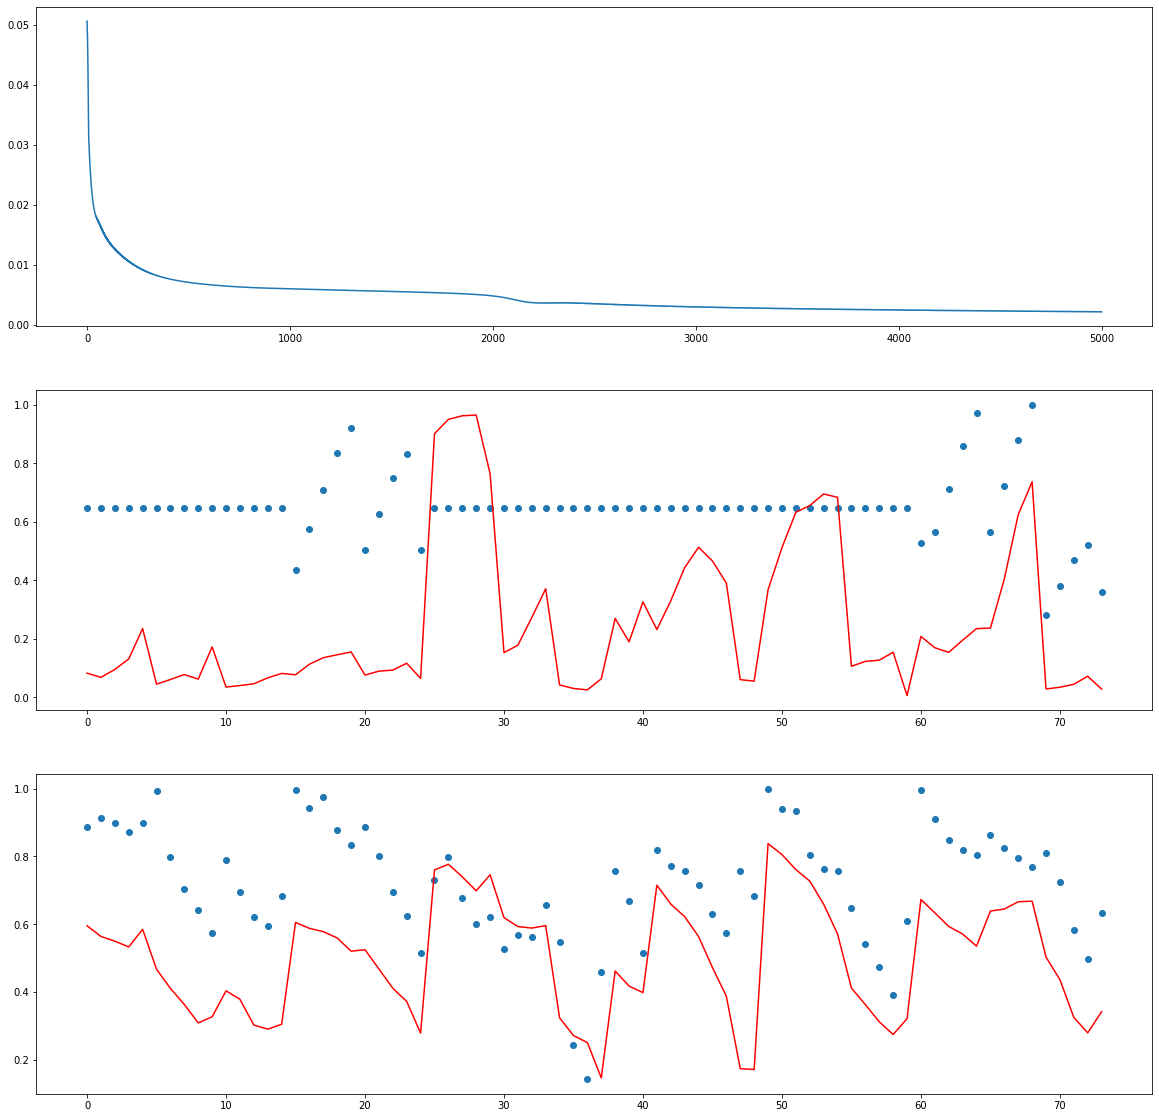

0.3820598735608019


In [0]:
fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.subplot(3, 1, 1)
plt.plot(errors)

for class_index in range(2):
    plt.subplot(3, 1, 2 + class_index)
    draw_class(class_index, normalized_test_data, 2)

plt.show()
print(rmse(network, Network.prepare_data(normalized_test_data, 2)))

In [0]:
import seaborn as sb
plt.figure(figsize=(12,12))
# corr = pd.DataFrame(np.corrcoef(network.weights[2]))
corr = pd.DataFrame(network.weights[2])
sb.heatmap(corr, square=True, cmap='PiYG')

In [0]:
class RegularizedNetwork(Network):
    def __init__(self, shape, activation_function, activation_function_derivative, l1=0, l2=0):
        super().__init__(shape, activation_function, activation_function_derivative)
        self.l1 = l1
        self.l2 = l2

            # обновление параметров нейронной сети (веса, смещения), сделав шаг градиентного спуска
    # на основе алгоритма обратного распространения ошибки
    # alpha - learning rate
    def back_prop_step(self, data, alpha):
        # значения dJ/db для каждого слоя
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        # значения dJ/dw (ошибки) для каждого слоя
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # для каждого примера из батча применяем бек пропогейшн
        for x, y in data:
            delta_nabla_b, delta_nabla_w = self.back_prop_single_example(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        eps = alpha / len(data)

        # обновляем параметры сети
        self.weights = [w - eps * nw - self.l1 * np.sign(w) - self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

In [0]:
network = RegularizedNetwork([18, 40, 60, 2], sigmoid, sigmoid_prime)
errors = network.SGD(normalized_train_data, 10000, 0.405, 2)